In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#from nltk.stem import LancasterStemmer,WordNetLemmatizer

from bs4 import BeautifulSoup
import re,string,unicodedata
import random

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from collections import Counter

np.random.seed(0)


# Load Dataset

In [2]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Text Preprocessing

### Denoising the text:
remove HTML tags, square brackets, punctuations and special characters.

### Remove Stopwords:
remove words which do not add useful information to the classifier.

In [4]:
#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text.lower()

imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [5]:
print('Sample Text after denoising:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after denoising:


'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done '

In [6]:
#text tokenizer
tokenizer=ToktokTokenizer()

#get list of stopwords
stop=set([re.sub(r'[^a-zA-z0-9\s]', '', st) for st in stopwords.words('english')])

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [7]:
print('Sample Text after filtering:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after filtering:


'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [8]:
'''Additional preprocessing'''
#stem the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [9]:
print('Sample Text after stemming:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after stemming:


'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Exploratory Data Analysis

C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


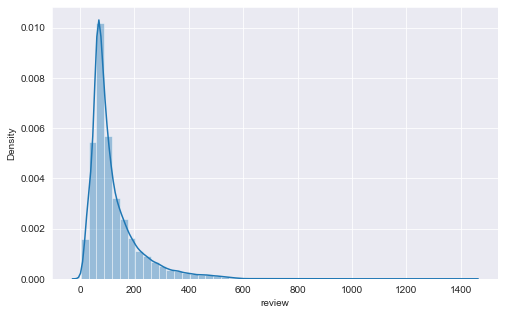

In [11]:
seqlen = imdb_data['review'].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

fig = seqlen_plot.get_figure()
fig.savefig("seqlen_plot.png")

<function matplotlib.pyplot.show(close=None, block=None)>

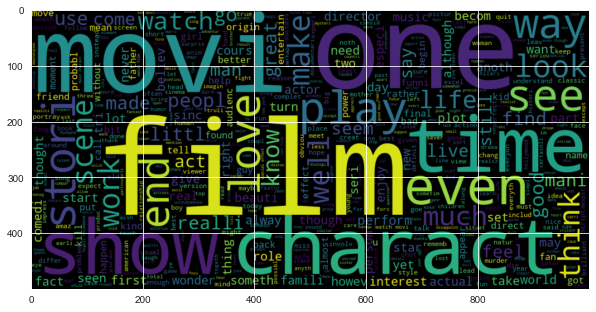

In [12]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(imdb_data[imdb_data['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

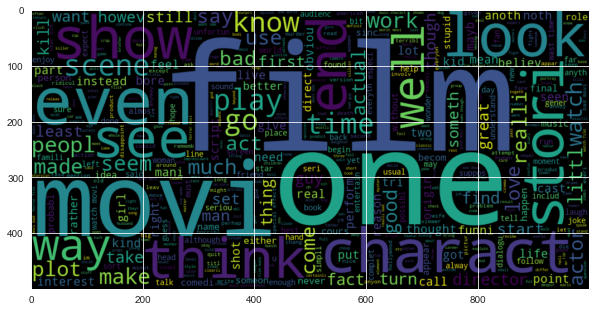

In [13]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(imdb_data[imdb_data['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [14]:
X,y = imdb_data['review'].values,imdb_data['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size = 0.3)
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 35000 samples
Test data has 15000 samples


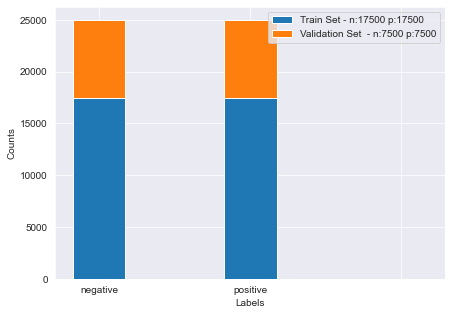

In [15]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

In [16]:
#vectorize dataset
def tokenize_text(x_train,y_train,x_val,y_val):
    word_list = []
 
    for sent in x_train:
        for word in sent.split():
            if word != '':
                word_list.append(word)
    
    #make vocab dictionary
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    train_sent,test_sent = [],[]
    for sent in x_train:
            train_sent.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])
    for sent in x_val:
            test_sent.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

    return np.array(train_sent), y_train,np.array(test_sent), y_val,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize_text(x_train,y_train,x_test,y_test)

<ipython-input-16-ecc834bfe9b5>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_sent), y_train,np.array(test_sent), y_val,onehot_dict


In [17]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


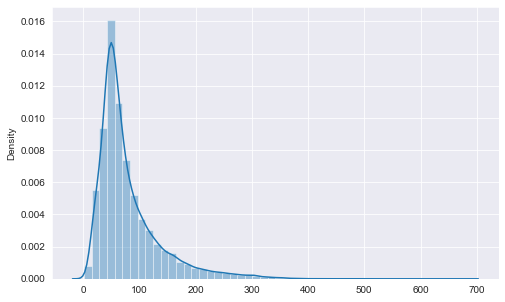

In [18]:
rev_len = [len(i) for i in x_train]
seqlen = pd.Series(rev_len)
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

In [19]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).describe()

count    35000.000000
mean        79.746943
std         56.140227
min          2.000000
25%         45.000000
50%         62.000000
75%         97.000000
max        682.000000
dtype: float64

In [20]:
#pad with zeros
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train,100)
x_test_pad = padding_(x_test,100)

# Discriminative Process for classification

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [22]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train.astype('int')))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [23]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input features: \n', sample_x)
print('Sample input labels: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input features: 
 tensor([[  0,   0,   0,  ...,   2, 308,   3],
        [  0,   0,   0,  ..., 487, 209,  82],
        [  0,   0,   0,  ..., 108, 586,   3],
        ...,
        [  0,   0,   0,  ...,  21,   1, 471],
        [  0,   0,   0,  ...,  24,  37, 821],
        [  0,   0,   0,  ...,  76, 380, 213]], dtype=torch.int32)
Sample input labels: 
 tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1], dtype=torch.int32)


### LSTM neural network model

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self,n_layers,vocab_size,hidden_dim,embedding_dim):
        super(LSTMClassifier,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.n_layers = n_layers
        self.vocab_size = vocab_size

        #embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = torch.nn.LSTM(input_size = embedding_dim, 
                                 hidden_size = self.hidden_dim,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 dropout = 0.2)

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        #linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
        

In [25]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [26]:
n_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 100
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)


LSTMClassifier(
  (embedding): Embedding(1001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [27]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [105]:
clip = 5
epochs = 5
best_loss = float('inf')
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break
        
        inputs, labels = inputs.to(device), labels.to(device) 
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(epoch+1,
    epochs, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100)
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss,epoch_val_loss))
        best_loss = epoch_val_loss
    print(70*'==')


Epoch[1/5], Train Loss: 0.6573 | Valid Loss: 0.6386 | Train Acc: 59.51 | Valid Acc: 62.74
Validation loss decreased (inf --> 0.638571).  Saving model ...
Epoch[2/5], Train Loss: 0.5293 | Valid Loss: 0.5884 | Train Acc: 74.44 | Valid Acc: 70.93
Validation loss decreased (0.638571 --> 0.588419).  Saving model ...
Epoch[3/5], Train Loss: 0.4143 | Valid Loss: 0.5537 | Train Acc: 81.14 | Valid Acc: 73.93
Validation loss decreased (0.588419 --> 0.553657).  Saving model ...
Epoch[4/5], Train Loss: 0.3346 | Valid Loss: 0.5266 | Train Acc: 85.87 | Valid Acc: 73.43
Validation loss decreased (0.553657 --> 0.526609).  Saving model ...
Epoch[5/5], Train Loss: 0.2375 | Valid Loss: 0.7060 | Train Acc: 90.54 | Valid Acc: 75.12


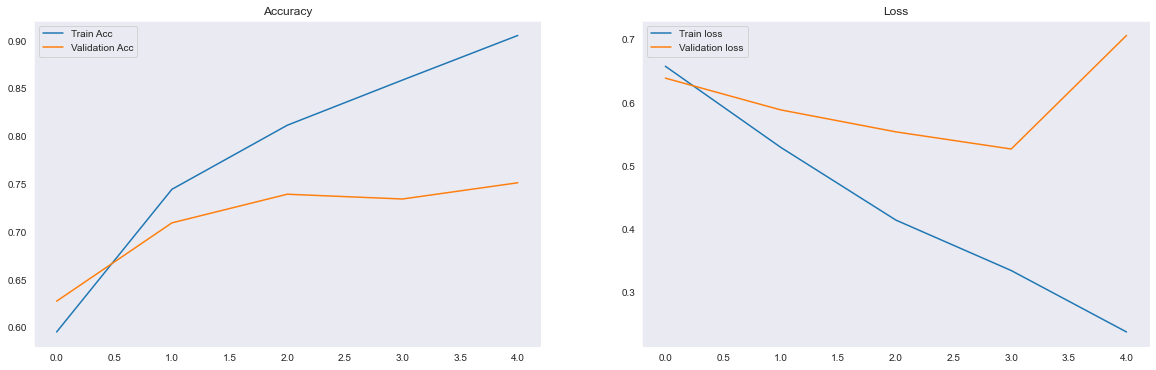

In [106]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [128]:
#evaluation on validation set
from sklearn.metrics import confusion_matrix

nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = model.init_hidden(batch_size)
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = model(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())

        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)

Text(0.5, 1.0, 'class 0 (specificity): 0.679 | class 1 (sensitivity): 0.826')

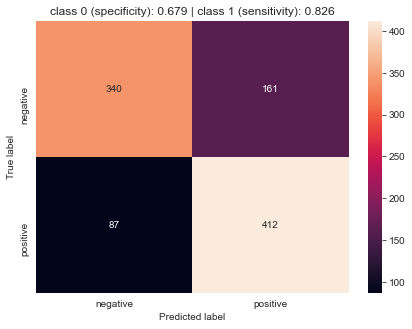

In [129]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

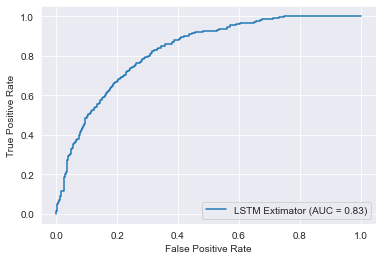

In [131]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [132]:
test_imdb['review']=test_imdb['review'].apply(simple_stemmer)
test_imdb['sentiment']=test_imdb['sentiment'].apply(lambda x : 1 if x == 'positive' else 0)

<ipython-input-132-c5665f78ca78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_imdb['review']=test_imdb['review'].apply(simple_stemmer)
<ipython-input-132-c5665f78ca78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_imdb['sentiment']=test_imdb['sentiment'].apply(lambda x : 1 if x == 'positive' else 0)


In [136]:
x_test_real,y_test_real = test_imdb['review'].values,test_imdb['sentiment'].values

def tokenize_test(x_test_real, vocab):
    test_sent=[]
    for sent in x_test_real:
        test_sent.append([vocab[word] for word in sent.split() if word in vocab.keys()])
    return np.array(test_sent)

x_test_real = tokenize_test(x_test_real, vocab)

<ipython-input-136-08acce9c61e5>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(test_sent)


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


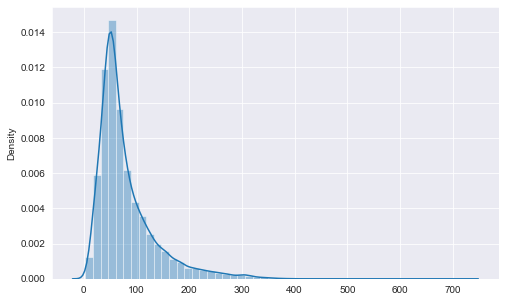

In [137]:
rev_len = [len(i) for i in x_test_real]
seqlen = pd.Series(rev_len)
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

In [138]:
x_real_pad = padding_(x_test_real,80)

In [139]:
test_data = TensorDataset(torch.from_numpy(x_real_pad), torch.from_numpy(y_test_real.astype('int')))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [145]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in test_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = model(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy on Real World data: {:.2f}".format(val_acc*100/len(test_loader.dataset)))

Test Accuracy on Real World data: 74.49


Text(0.5, 1.0, 'class 0 (specificity): 0.617 | class 1 (sensitivity): 0.874')

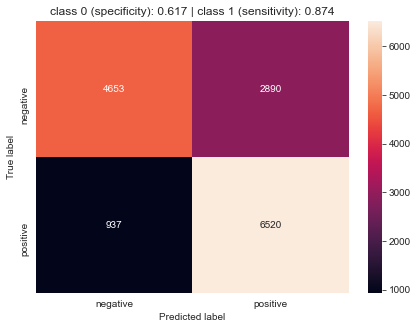

In [146]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

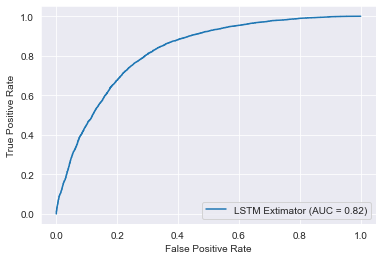

In [147]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [149]:
def predict_text(text):
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,80))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

sentiment_dict = {1:'positive', 0:'negtive'}

In [160]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

24 got best spyadventur seri tv ever air whole idea tell stori 24 hour real time period dazzl style film pace hook us watch jack bauer one greatest protagonist tv seri long time rate along simpson x file three favorit tv seri first episod begin conspiraci assassin us senat david palmer also run presid bauer call offic order discov behind time figur daughter path unkwown flee bedroom thu begin adventur best polit style what best alway take place real time make tv seri real work origin time almost everi program tv seem show us thing
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9988149404525757


In [161]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

know movi peopl watch must seen differ joseph smith prophet restor one saw think movi well done inspir think definit worth watch appar outset lot care went make film background sceneri beauti think film good job portray joseph smith man prophet joseph spiritu experi portray tast rever would definit recommend watch movi
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9868519902229309


In [162]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

film exhibit dear ironi shaggi dog roundabout stori line woven subtl cultur refer classic parallel master use rich satur color fabul rendit chase scene ala keyston cop ensembl work cast entir crew charm liter els could go film speak everyon deft poignant use mani univers archetyp that make film deep satisfi matur student film find check contain vital element sure bergorra godfath would serv perfectli follow tragedi mandatori satyr play sweetli bind collect cathart wound get thee theatr see film treat uniqu masterpiec
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9983419179916382


In [163]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

bought 3 ok titl grey matter novelti see sherriff rosco non dukesofhazzard role intrigu review warn pretti bore tale top secret govern experi gone awri ye plenti establish shot especi hous pool front charact interior nondescript guess filmmak worri might forget keep tip us first show outsid build actual kinda funni awhil pool shot feel like tv channel station identif logo remind us watch grey matter also enjoy two bout name call one point angri test subject taunt somebodi charg call scientif btch inadequ insult sever scene later differ subject let steam mutter scientif btard sound awkward someday movi disappear forev anoth decad like imposs find copi almost like never happen
Actual sentiment is  : negtive
Predicted sentiment is positive with a probability of 0.9813922047615051


In [169]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

obvious raw feed video smarter us wast money rent flick make million video rental low budget invest go pay big financ rest stop ii unfortun figur spent maximum hundr thousand dollar american hire actor rent rest stop local burn truck drag motorcycl along behind truck bit plu pay technic stuff that smart guy knock geniu promot stinker good monetari return premis movi good could realli adequ horror movi fail deliv clear stori line alway look gem upstart film compani find neither im sorri wast 3 99 plu tax find
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.9935796037316322


In [168]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

okay fair movi interest concept given script rewrit decent actor budget might fairli decent cult flick instead mst3k fodder turn still better armageddon
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.9937954777851701


In [166]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

adapt bond plain rip mediocr charact sketch ian fleme would approv film goe worst 007 movi older even haggard conneri tri reliv past 12 year later result humourless tacki version classic hero give roger moor day
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.9623347148299217


In [167]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

start lose faith film recent inund typic genr hollywood film stori line fail camera work mere copi last film similiar tast saw zentropa europa faith renew metaphor storylin enthral use color black white visual stimul narrat max von sydow take spellbound journey everi step way engross europa 1945 seen death put screen hundr thousand way beauti film take everi slow move moment lead death unlik mani film cut one second show exampl knife forc watch devast yet sensuou beauti man final moment think take someth differ away movi tri say definit worth take time find realli mean would love talk depth film one wish send email enjoy
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9976577758789062
